<a href="https://colab.research.google.com/github/shima2920/Kaggle/blob/main/Restaurant_Revenue_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
! pip install -q kaggle

In [61]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"yutashimamura","key":"34f60f3855821ab47e98310e4ed27da4"}'}

In [62]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [63]:
! cp kaggle.json ~/.kaggle/

In [64]:
! chmod 600 ~/.kaggle/kaggle.json

In [65]:
 ! kaggle datasets list

ref                                                       title                                         size  lastUpdated          downloadCount  
--------------------------------------------------------  -------------------------------------------  -----  -------------------  -------------  
michau96/restaurant-business-rankings-2020                Restaurant Business Rankings 2020             16KB  2021-01-30 14:20:45           3091  
gpreda/reddit-wallstreetsbets-posts                       Reddit WallStreetBets Posts                    8MB  2021-02-24 07:59:48           1684  
yorkehead/stock-market-subreddits                         Stock Market Subreddits                        1MB  2021-01-29 13:53:50            324  
aagghh/crypto-telegram-groups                             Crypto telegram groups                       297MB  2021-02-02 09:58:25            197  
timoboz/superbowl-history-1967-2020                       Superbowl History 1967 - 2020                  2KB  2020-02-

In [66]:
! kaggle competitions download -c restaurant-revenue-prediction

sampleSubmission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


# This is Kaggle Competition "Restaurant Revenue Prediction"

> インデントされたブロック



https://www.kaggle.com/c/restaurant-revenue-prediction/notebooks


## ***Summary***

**Prediction result without removing the outlier by LightGBM**


 The rmse of prediction is: 3107519.3078672164


 **Removed the outlier of revenue, prediction accuracy was getting better(02/18/2021)**

 The rmse of prediction is: 1764572.8979796541


**Prediction by LightGBM with Optuna(02/18/2021)**

The rmse of prediction is: 2042315.1675036596

*rmse was not good compare to previous one, but i could get higher score than previous ones on Leaderboard.

**Next Step**


*   Try other model
*   Understand each regression model
*   Improve Preprocessing




In [121]:
from tqdm import tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder#Label Encoding
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
#import optuna.integration.lightgbm as lgb #LightLGBのハイパーパラメータチューニングモジュールであるOptunaをimport
import lightgbm as lgb_original
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import xgboost as XGBClassifier
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Dropout #Dense : ニューラルネットの層を定義？
from keras.models import Sequential# 複雑なニューラルネットワークモデルを簡略化するためのモデルの一つであるSequentialモデル
from sklearn.preprocessing import StandardScaler #標準化



#Validation
from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import KFold


#イテレータ, ループ処理を実行してくれる
import itertools

pd.set_option("display.max_rows", 10000)
pd.set_option('display.max_columns', 1000)
%matplotlib inline

## Import Data

In [122]:
train = pd.read_csv('train.csv.zip')
test = pd.read_csv('test.csv.zip')
ample_submission = pd.read_csv('sampleSubmission.csv.zip')

In [123]:
train.head()

,Id,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,P17,P18,P19,P20,P21,P22,P23,P24,P25,P26,P27,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
0,0,07/17/1999,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,2,5,4,5,5,3,5,5.0,1,2,2,2,4,5,4,1,3,3,1,1,1.0,4.0,2.0,3.0,5,3,4,5,5,4,3,4,5653753.0
1,1,02/14/2008,Ankara,Big Cities,FC,4,5.0,4.0,4.0,1,2,5,5,5,5,1,5,5.0,0,0,0,0,0,3,2,1,3,2,0,0,0.0,0.0,3.0,3.0,0,0,0,0,0,0,0,0,6923131.0
2,2,03/09/2013,Diyarbakır,Other,IL,2,4.0,2.0,5.0,2,3,5,5,5,5,2,5,5.0,0,0,0,0,0,1,1,1,1,1,0,0,0.0,0.0,1.0,3.0,0,0,0,0,0,0,0,0,2055379.0
3,3,02/02/2012,Tokat,Other,IL,6,4.5,6.0,6.0,4,4,10,8,10,10,8,10,7.5,6,4,9,3,12,20,12,6,1,10,2,2,2.5,2.5,2.5,7.5,25,12,10,6,18,12,12,6,2675511.0
4,4,05/09/2009,Gaziantep,Other,IL,3,4.0,3.0,4.0,2,2,5,5,5,5,2,5,5.0,2,1,2,1,4,2,2,1,2,1,2,3,3.0,5.0,1.0,3.0,5,1,3,2,3,4,3,3,4316715.0


**Data description**
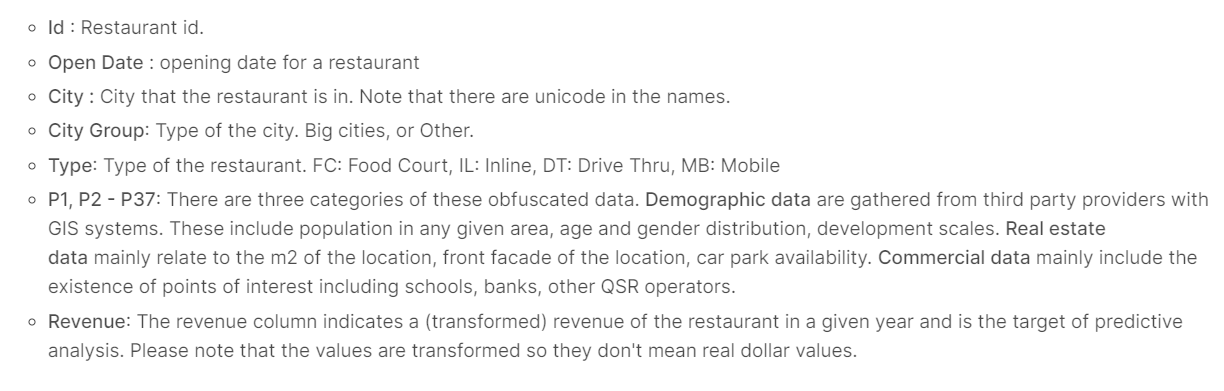


In [124]:
test.head()

,Id,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,P17,P18,P19,P20,P21,P22,P23,P24,P25,P26,P27,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37
0,0,01/22/2011,Niğde,Other,FC,1,4.0,4.0,4.0,1,2,5,4,5,5,5,3,4.0,0,0,0,2,0,5,5,3,1,4,0,0,0.0,0.0,2.0,3.0,0,0,0,0,0,0,0,0
1,1,03/18/2011,Konya,Other,IL,3,4.0,4.0,4.0,2,2,5,3,4,4,2,4,5.0,0,0,0,0,0,5,5,3,2,1,0,0,0.0,0.0,1.0,3.0,0,0,0,0,0,0,0,0
2,2,10/30/2013,Ankara,Big Cities,FC,3,4.0,4.0,4.0,2,2,5,4,4,5,4,5,5.0,0,0,0,0,0,5,5,5,5,5,0,0,0.0,0.0,2.0,3.0,0,0,0,0,0,0,0,0
3,3,05/06/2013,Kocaeli,Other,IL,2,4.0,4.0,4.0,2,3,5,4,5,4,3,4,5.0,0,0,0,0,4,4,4,3,2,2,0,0,0.0,0.0,2.0,3.0,0,4,0,0,0,0,0,0
4,4,07/31/2013,Afyonkarahisar,Other,FC,2,4.0,4.0,4.0,1,2,5,4,5,4,3,5,4.0,0,0,0,0,0,1,5,3,1,1,0,0,0.0,0.0,5.0,3.0,0,0,0,0,0,0,0,0


In [125]:
train.shape

(137, 43)

In [126]:
test.shape

(100000, 42)

# Train data Summary

In [127]:
from scipy import stats
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

resumetable(train)[:100]

Dataset Shape: (137, 43)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,Id,int64,0,137,0,1,2,7.10
1,Open Date,object,0,134,07/17/1999,02/14/2008,03/09/2013,7.05
2,City,object,0,34,İstanbul,Ankara,Diyarbakır,3.72
3,City Group,object,0,2,Big Cities,Big Cities,Other,0.99
4,Type,object,0,3,IL,FC,IL,1.05
5,P1,int64,0,8,4,4,2,2.56
6,P2,float64,0,8,5,5,4,2.46
7,P3,float64,0,8,4,4,2,1.79
8,P4,float64,0,6,4,4,5,1.93
9,P5,int64,0,7,2,1,2,1.73


In [128]:
resumetable(test)[:100]

Dataset Shape: (100000, 42)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,Id,int64,0,100000,0,1,2,16.61
1,Open Date,object,0,310,01/22/2011,03/18/2011,10/30/2013,8.26
2,City,object,0,57,Niğde,Konya,Ankara,4.20
3,City Group,object,0,2,Other,Other,Big Cities,1.00
4,Type,object,0,4,FC,IL,FC,1.14
5,P1,int64,0,9,1,3,3,2.62
6,P2,float64,0,9,4,4,4,2.40
7,P3,float64,0,7,4,4,4,1.63
8,P4,float64,0,7,4,4,4,1.86
9,P5,int64,0,6,1,2,2,1.67


The number of "City" paramter is more than train ones.

So, need to handle with label encoding carefully.

# Check missing data

In [129]:
#train
total = train.isnull().sum().sort_values(ascending=False)
percent = ((train.isnull().sum()/train.isnull().count())*100).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(434)

,Total,Percent
revenue,0,0.0
P6,0,0.0
P14,0,0.0
P13,0,0.0
P12,0,0.0
P11,0,0.0
P10,0,0.0
P9,0,0.0
P8,0,0.0
P7,0,0.0




*   There are no missing value.



# Visualization
First of all, I'll check the overall numerical info.

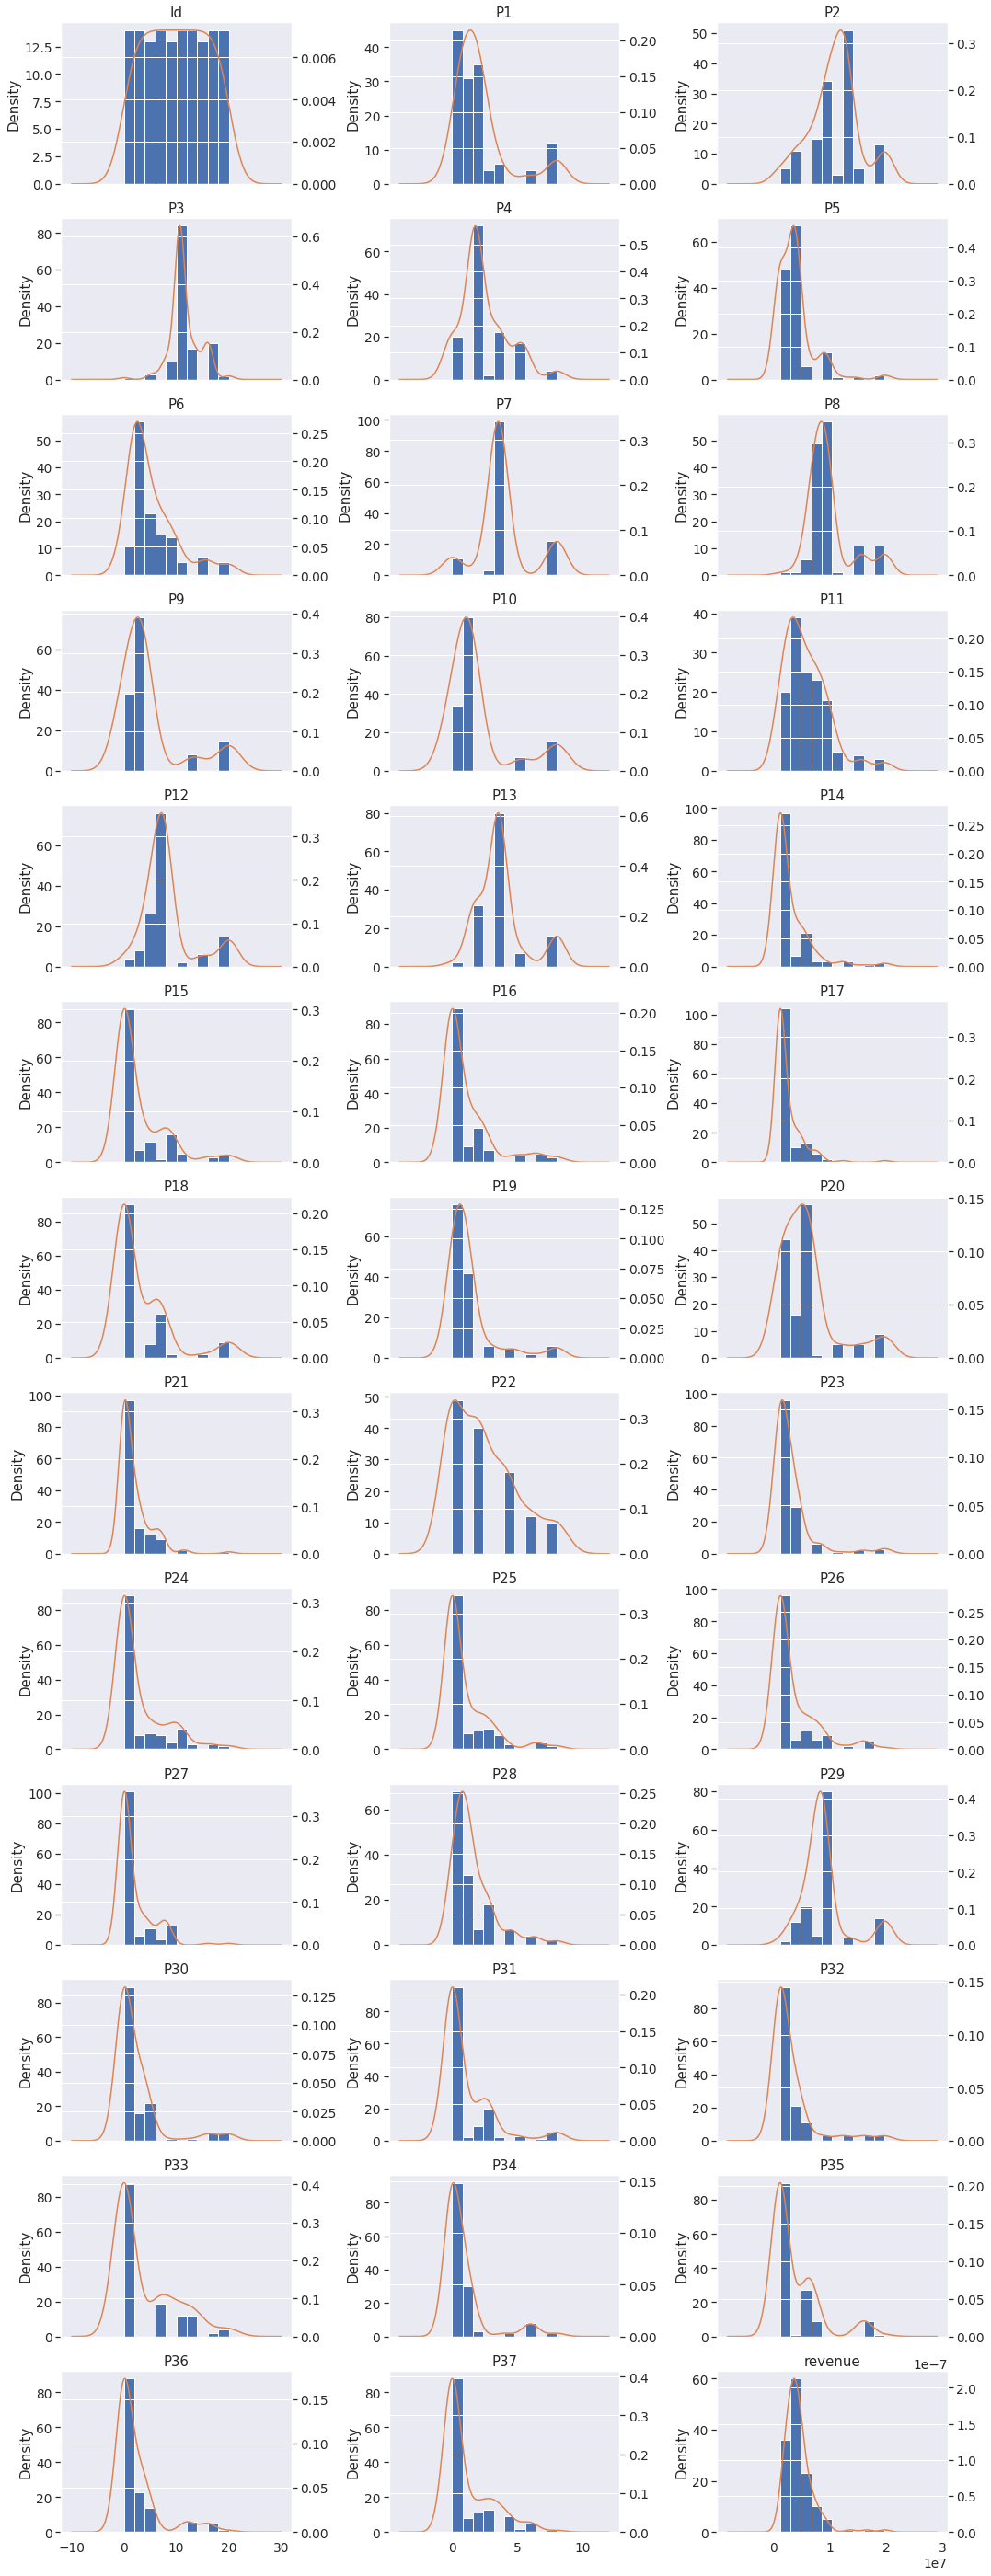

In [130]:
#Seperate categorical from numberical variables for analysis 
numerical_features = train.select_dtypes([np.number]).columns.tolist()
categorical_features = train.select_dtypes(exclude = [np.number,np.datetime64]).columns.tolist()

#train[numerical_features].hist(figsize=(30, 35), layout=(12, 4));
k = len(train[numerical_features].columns)
n = 3
m = (k - 1) // n + 1 ## Floor Division (also called Integer Division)
fig, axes = plt.subplots(m, n, figsize=(n * 5, m * 3))
for i, (name, col) in enumerate(train[numerical_features].iteritems()):
    r, c = i // n, i % n
    ax = axes[r, c]
    col.hist(ax=ax)
    ax2 = col.plot.kde(ax=ax, secondary_y=True, title=name)
    ax2.set_ylim(0)

fig.tight_layout()

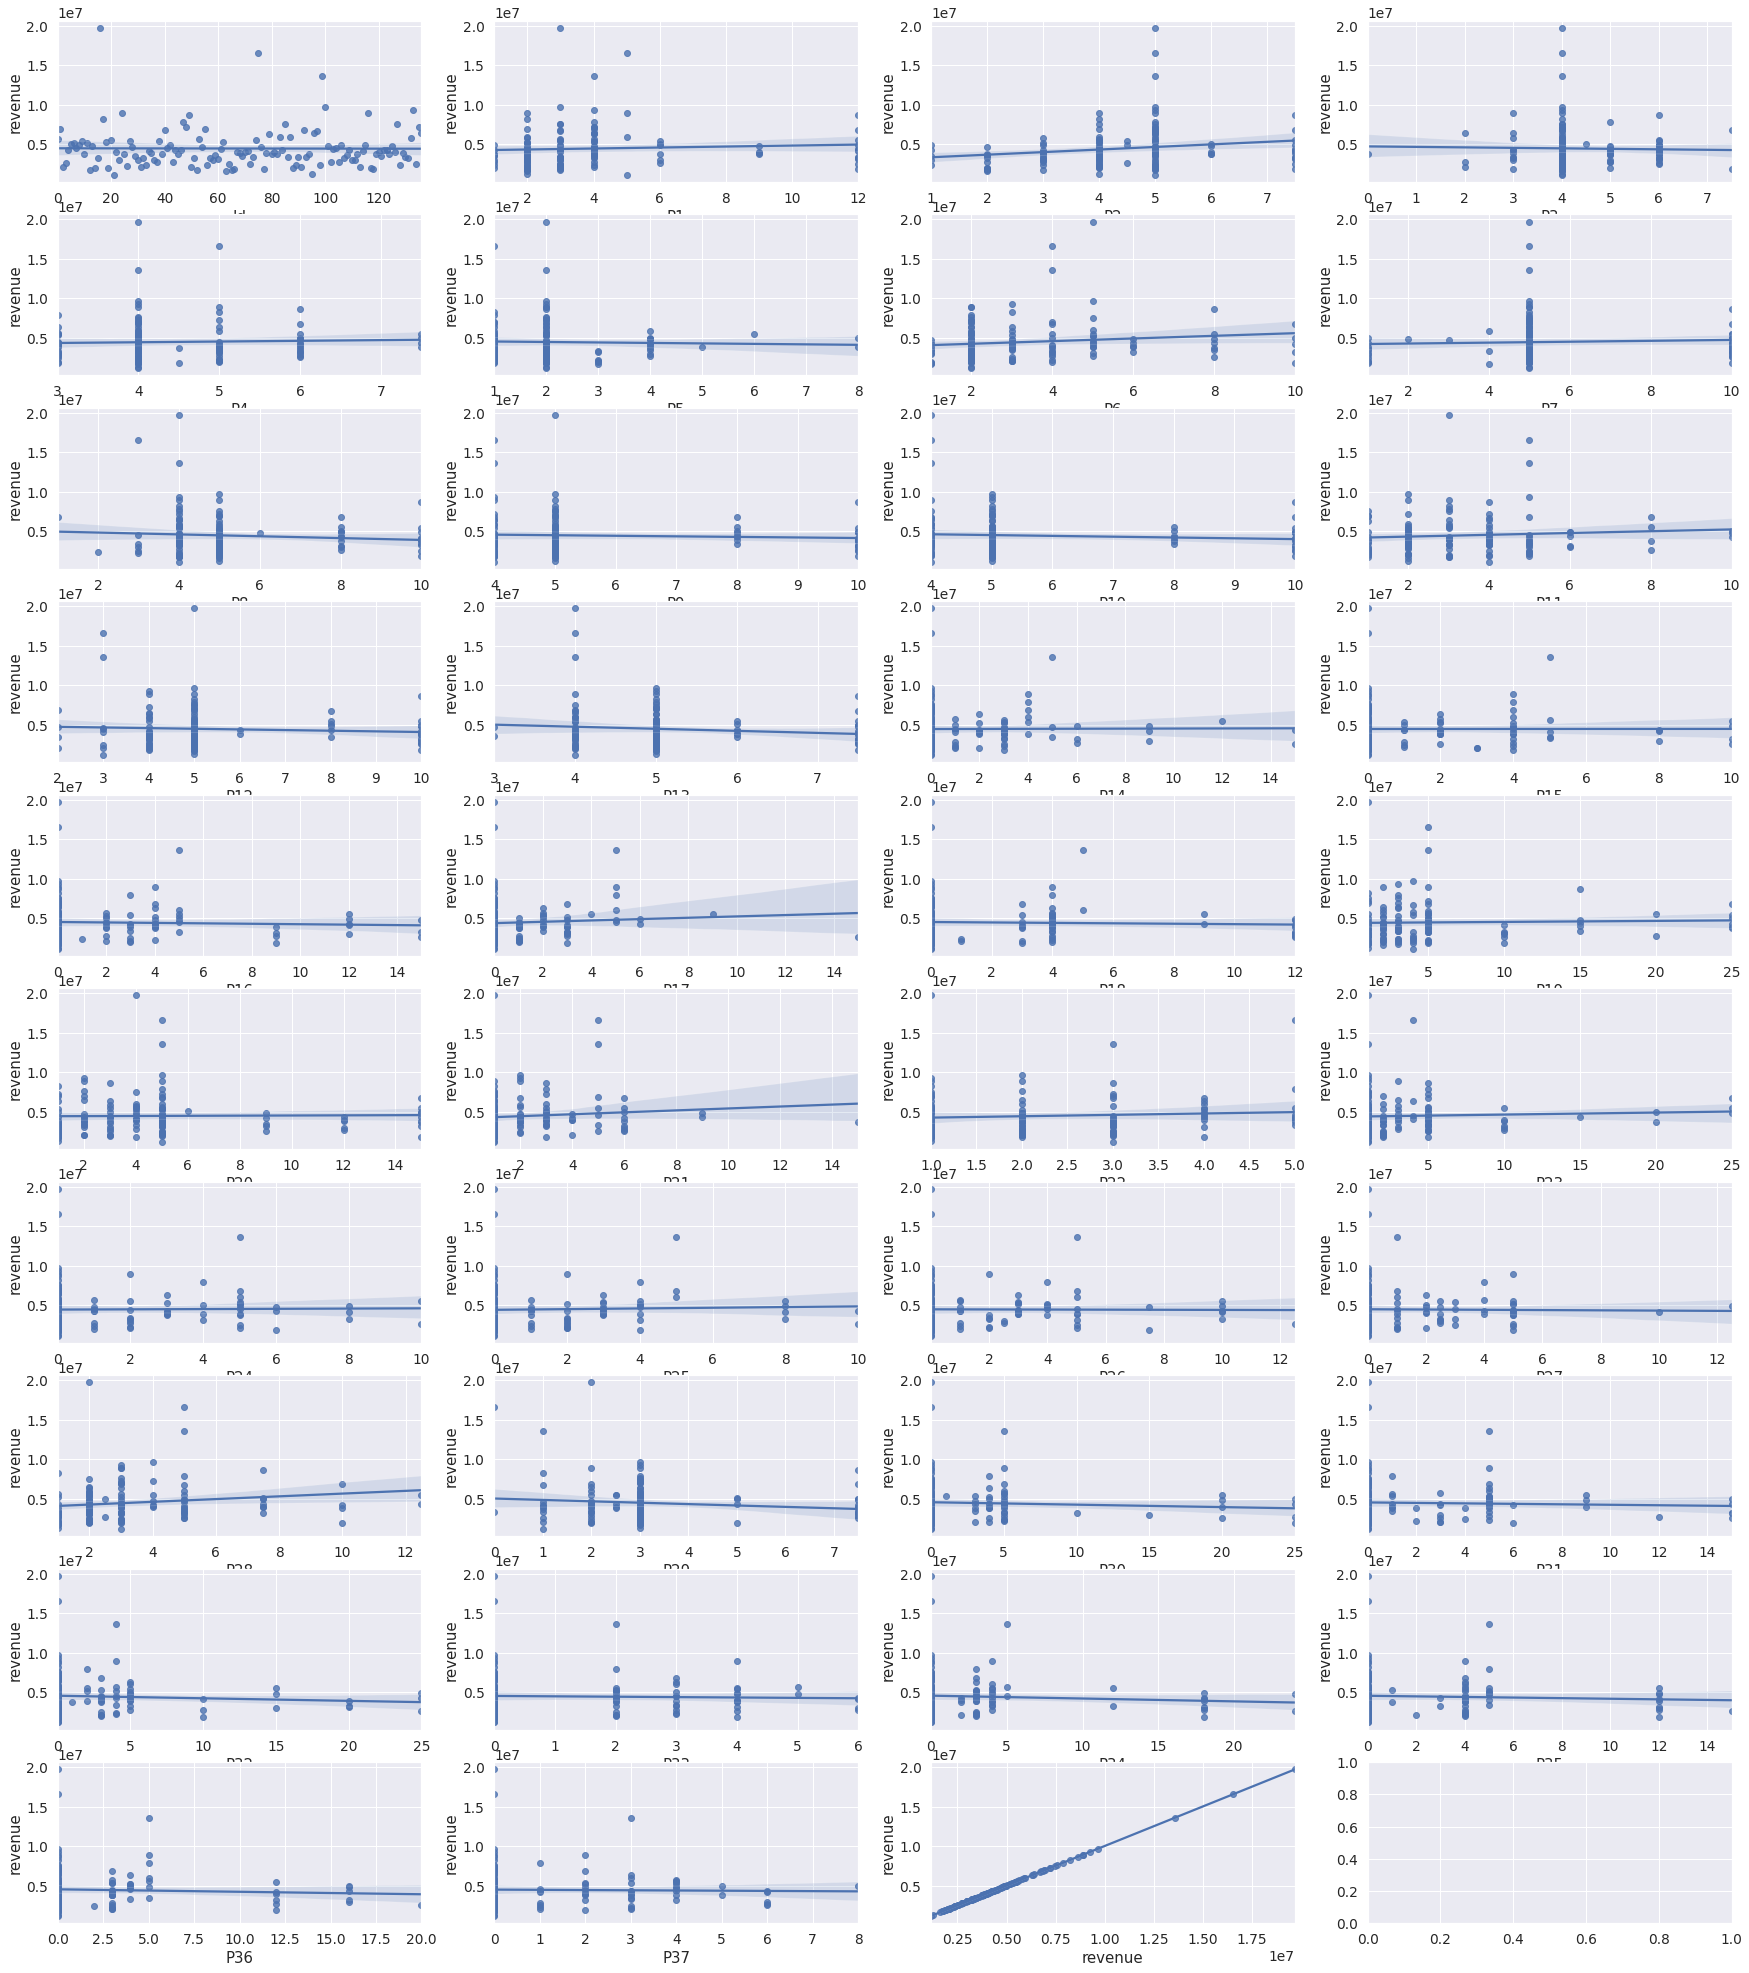

In [131]:
numerical_features = train.select_dtypes([np.number]).columns.tolist()
fig, ax = plt.subplots(10, 4, figsize=(30, 35))
for variable, subplot in zip(numerical_features, ax.flatten()):
    sns.regplot(x=train[variable], y=train['revenue'], ax=subplot)

## Correlation matrix

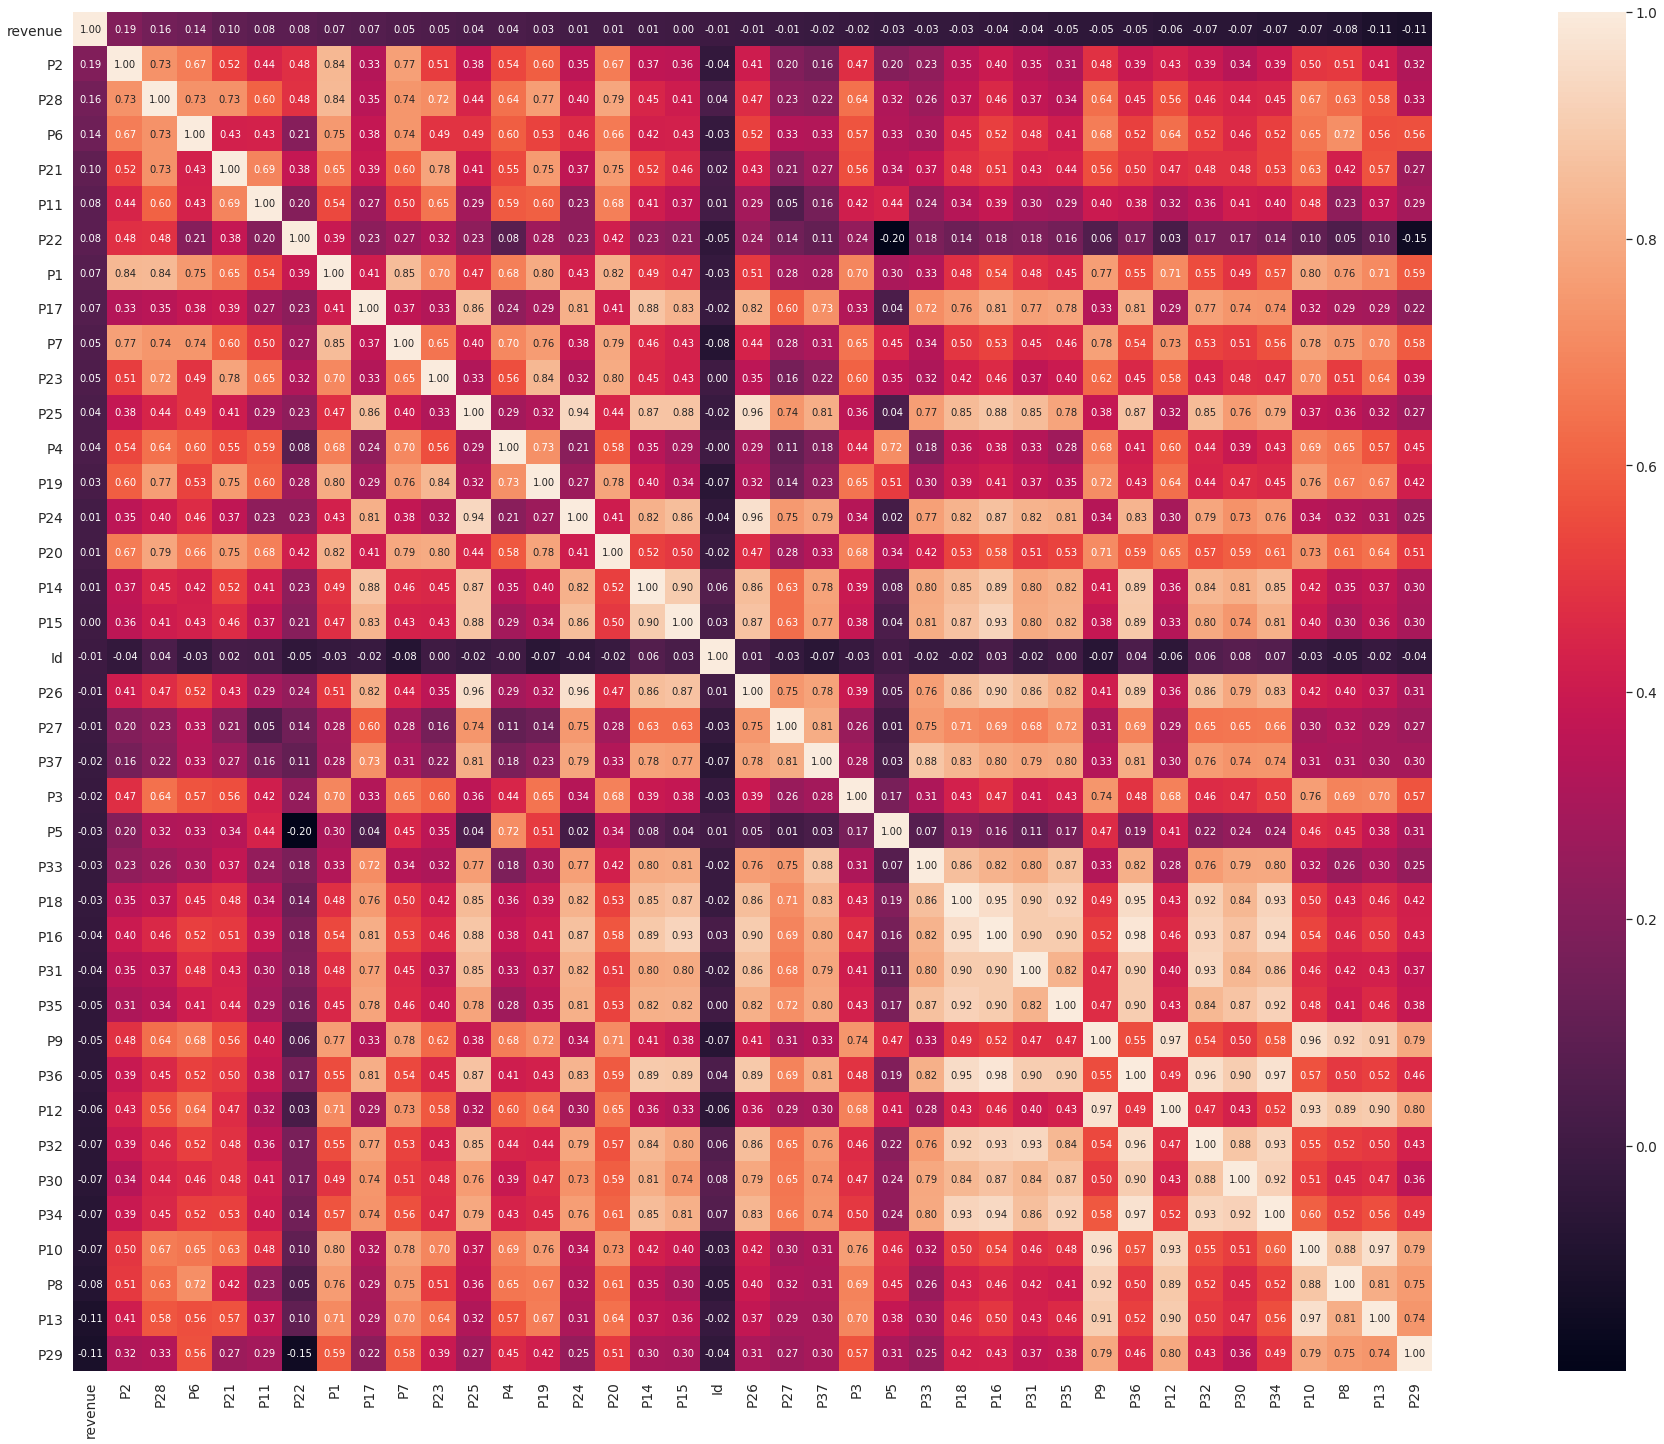

In [132]:
#correlation matrix
plt.figure(figsize=(45,25))
k = len(train.columns) #number of variables for heatmap
corrmat = train.corr()
cols = corrmat.nlargest(k, 'revenue')['revenue'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

P1-29 parameters don't have strong correlation with revenue.

Next, check the relation between revenue and each single parameter especially Open date, City, City Group.

To check relationship between Opendate and revenue, split datetime to Year, Month and Day.

['Open Date', 'City', 'City Group', 'Type']


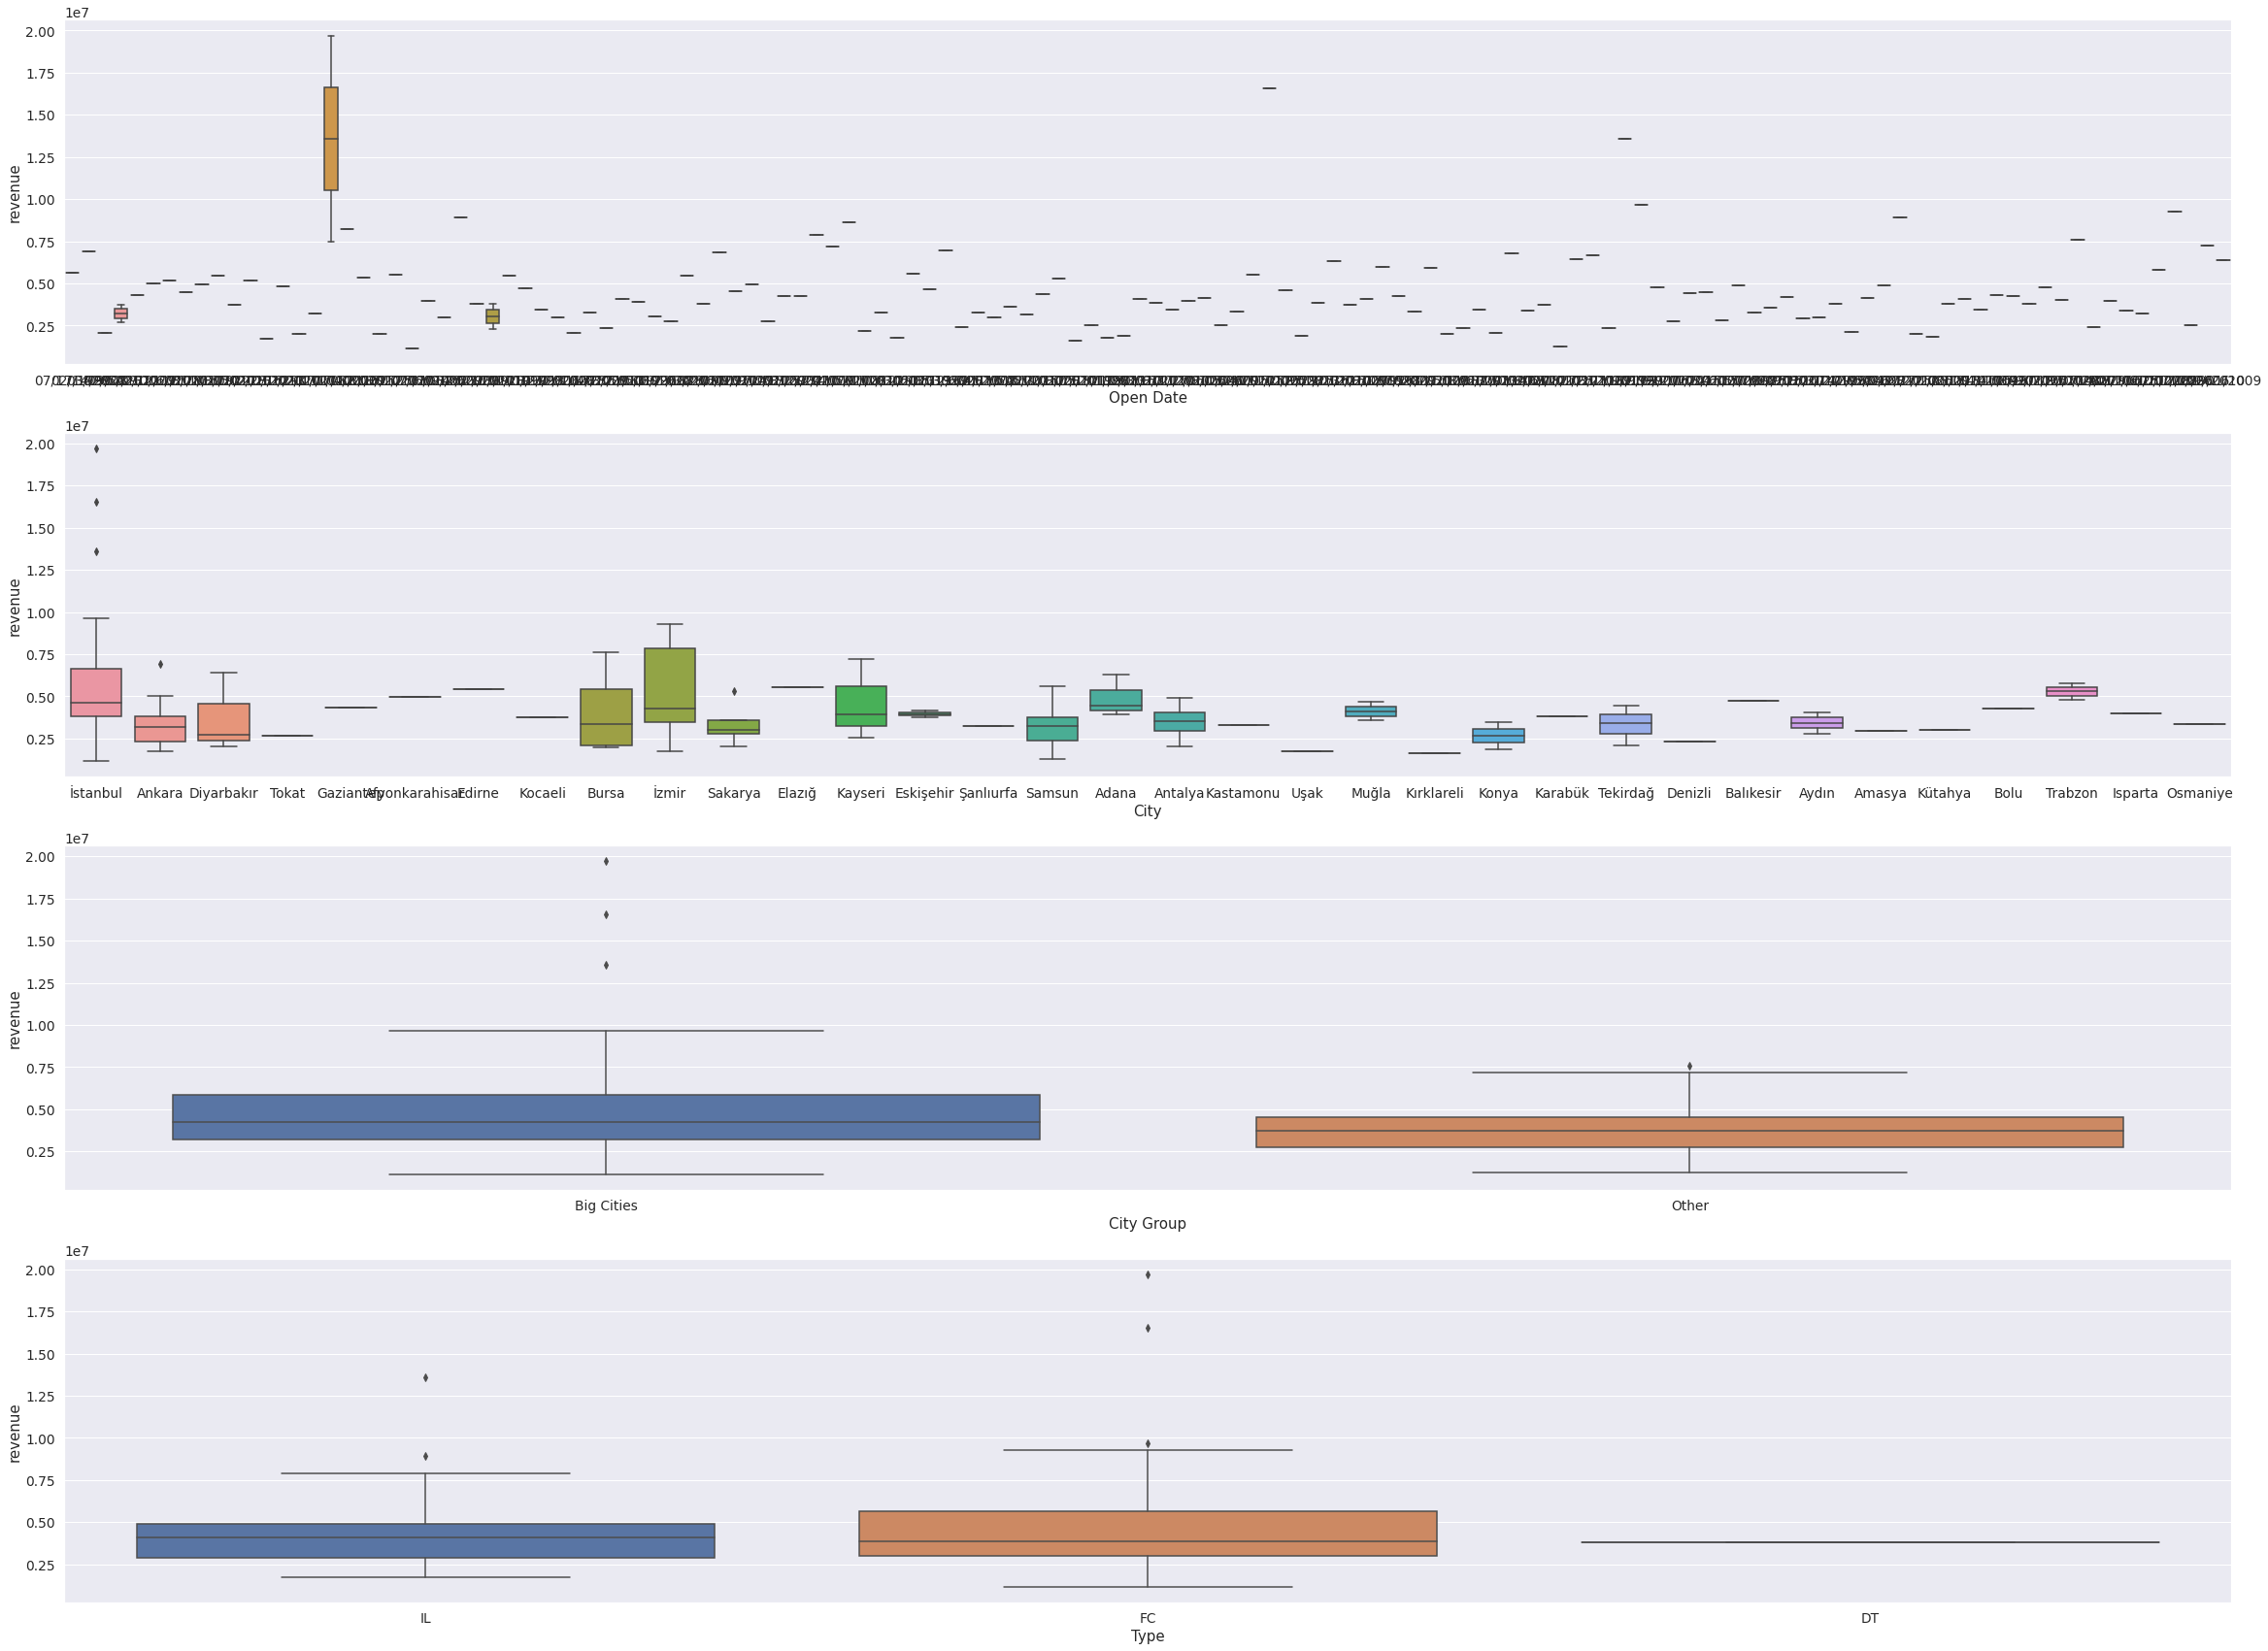

In [138]:
categorical_features = train.select_dtypes(exclude = [np.number,np.datetime64]).columns.tolist()
print(categorical_features)

fig, ax = plt.subplots(len(categorical_features), 1, figsize=(40, 30))
for var, subplot in zip(categorical_features, ax.flatten()):
    sns.boxplot(x=var, y='revenue', data=train, ax=subplot)

# Remove the outlier of revenue

---



/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


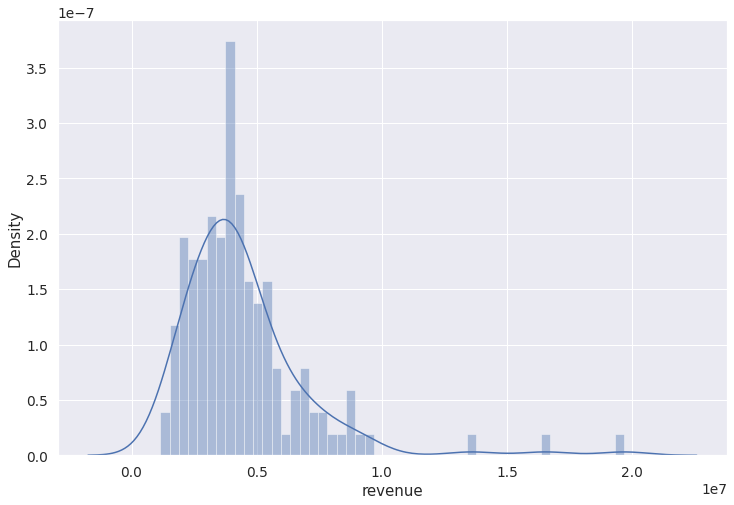

<Figure size 432x288 with 0 Axes>

In [134]:
plt.figure(figsize=(12,8))
sns.distplot( train['revenue'],  bins=50, kde=True);
fig = plt.figure()

**There are some outlier that is over 1.0, need to remove these one.**

**Let's remove these outlier.**

In [80]:
train.shape

(137, 43)

In [81]:
###上位〇〇%, 下位△△%をulimit/llimitの値に置き換える(外れ値の除去)####################################
for col in ["revenue"]:
    ulimit = np.percentile(train[col].values, 97.8)
    #llimit = np.percentile(train[col].values, 0.5)
    train[col].iloc[train[col]>ulimit] = ulimit
    #train[col].iloc[train[col]<llimit] = llimit

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


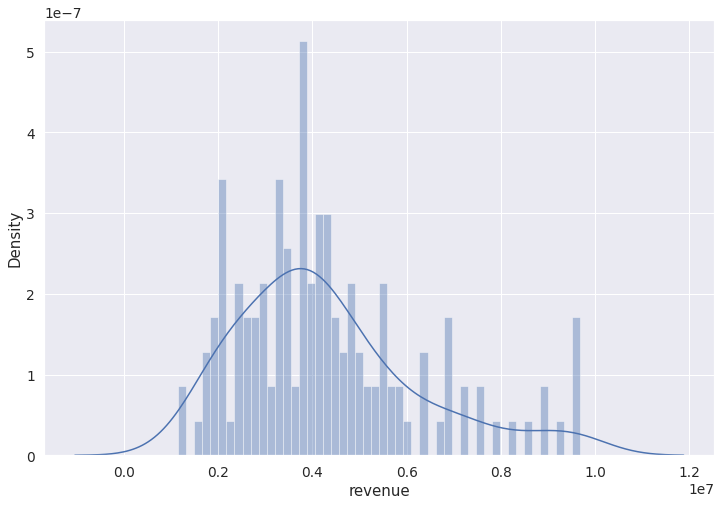

<Figure size 432x288 with 0 Axes>

In [82]:
plt.figure(figsize=(12,8))
sns.distplot( train['revenue'],  bins=50, kde=True);
fig = plt.figure()

In [83]:
train.shape

(137, 43)

In [84]:
train.to_csv('train_drop_over_1000000.csv', index=False)

## Split the datetime

Split the Open Date into Year, Month, Day




In [85]:
train["Open Date"] = pd.to_datetime(train["Open Date"])
train["Year"] = train["Open Date"].apply(lambda x:x.year)
train["Month"] = train["Open Date"].apply(lambda x:x.month)
train["Day"] = train["Open Date"].apply(lambda x:x.day)
train = train.drop(["Open Date"], axis = 1)

In [86]:
test["Open Date"] = pd.to_datetime(test["Open Date"])
test["Year"] = test["Open Date"].apply(lambda x:x.year)
test["Month"] = test["Open Date"].apply(lambda x:x.month)
test["Day"] = test["Open Date"].apply(lambda x:x.day)
test = test.drop(["Open Date"], axis = 1)

## Visualize the relation between revenue and other parameters

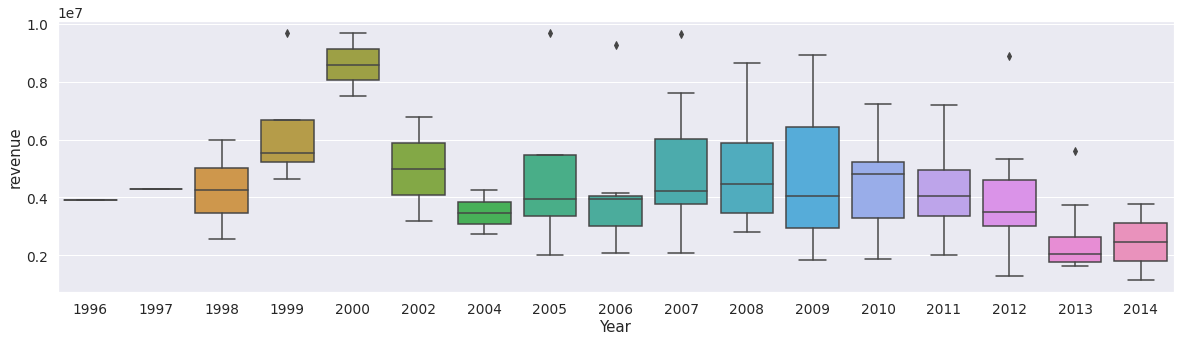

In [87]:
import seaborn as sn
fig1,ax3 = plt.subplots()
fig1.set_size_inches(20,5)
sns.boxplot(data=train,x="Year",y="revenue",orient="v",ax=ax3)

The restaurant open in 2000 has high revenue.


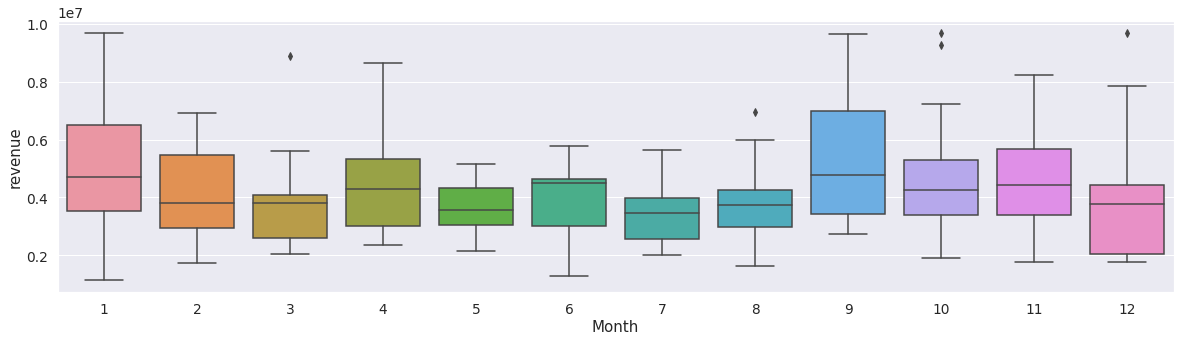

In [88]:
import seaborn as sn
fig1,ax3 = plt.subplots()
fig1.set_size_inches(20,5)
sns.boxplot(data=train,x="Month",y="revenue",orient="v",ax=ax3)

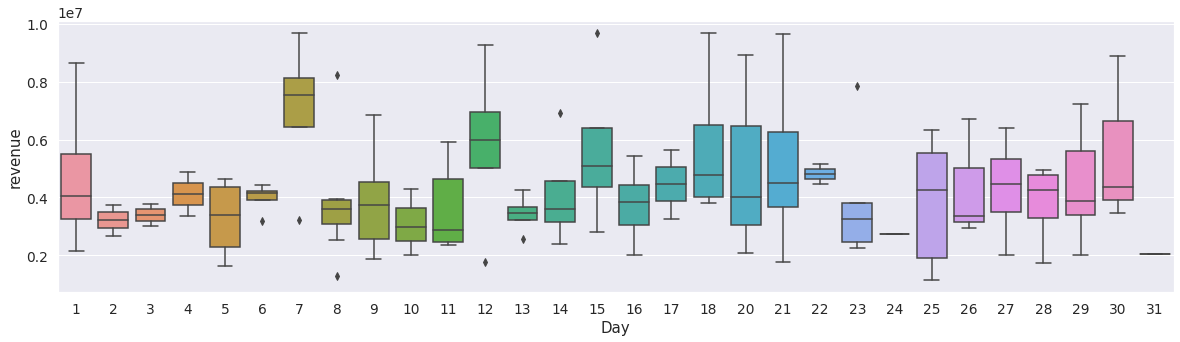

In [89]:
import seaborn as sn
fig1,ax = plt.subplots()
fig1.set_size_inches(20,5)
sns.boxplot(data=train,x="Day",y="revenue",orient="v",ax=ax)

Get the relationship between City Group and revenue

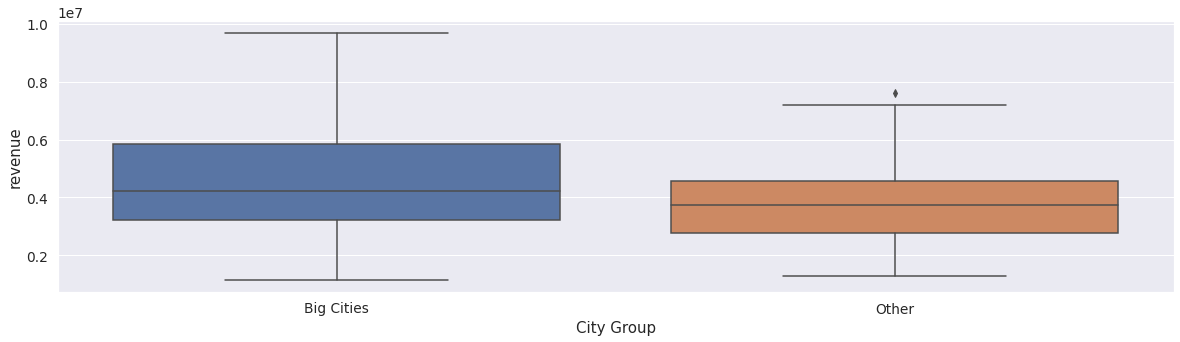

In [90]:
import seaborn as sn
fig1,ax = plt.subplots()
fig1.set_size_inches(20,5)
sns.boxplot(data=train,x="City Group",y="revenue",orient="v",ax=ax)

Of course, Big Cities's revenue is higher than Other. 

Get the relationship between City and revenue

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]),
 <a list of 34 Text major ticklabel objects>)

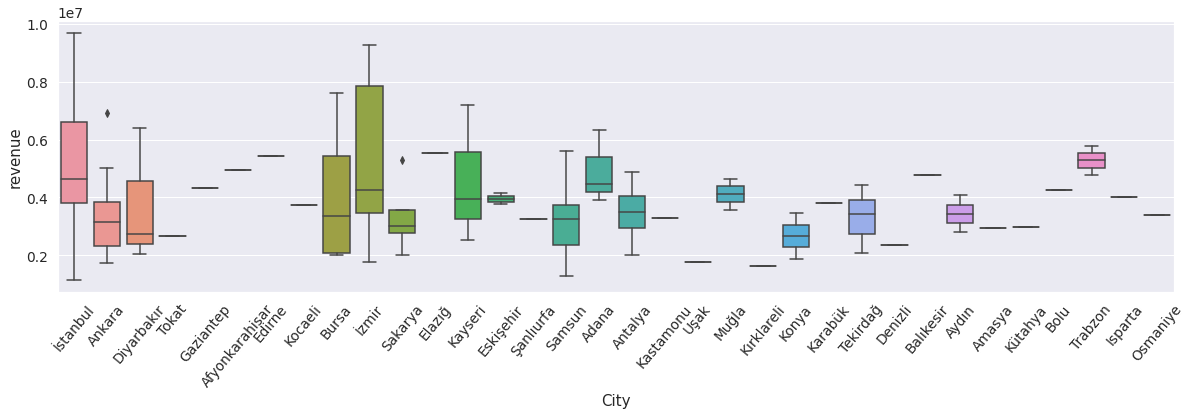

In [91]:
import seaborn as sn
fig1,ax = plt.subplots()
fig1.set_size_inches(20,5)
sns.boxplot(data=train,x="City",y="revenue",orient="v",ax=ax)
plt.xticks(rotation=50)

**There are some outlier, so need to remove.**

# Preprocessing the data

**Label encoding**

As i mentioned on first part of this page, the number of variable in "City" columns is different between train and test data.


In [92]:
train.head()

,Id,City,City Group,Type,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,P17,P18,P19,P20,P21,P22,P23,P24,P25,P26,P27,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue,Year,Month,Day
0,0,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,2,5,4,5,5,3,5,5.0,1,2,2,2,4,5,4,1,3,3,1,1,1.0,4.0,2.0,3.0,5,3,4,5,5,4,3,4,5653753.0,1999,7,17
1,1,Ankara,Big Cities,FC,4,5.0,4.0,4.0,1,2,5,5,5,5,1,5,5.0,0,0,0,0,0,3,2,1,3,2,0,0,0.0,0.0,3.0,3.0,0,0,0,0,0,0,0,0,6923131.0,2008,2,14
2,2,Diyarbakır,Other,IL,2,4.0,2.0,5.0,2,3,5,5,5,5,2,5,5.0,0,0,0,0,0,1,1,1,1,1,0,0,0.0,0.0,1.0,3.0,0,0,0,0,0,0,0,0,2055379.0,2013,3,9
3,3,Tokat,Other,IL,6,4.5,6.0,6.0,4,4,10,8,10,10,8,10,7.5,6,4,9,3,12,20,12,6,1,10,2,2,2.5,2.5,2.5,7.5,25,12,10,6,18,12,12,6,2675511.0,2012,2,2
4,4,Gaziantep,Other,IL,3,4.0,3.0,4.0,2,2,5,5,5,5,2,5,5.0,2,1,2,1,4,2,2,1,2,1,2,3,3.0,5.0,1.0,3.0,5,1,3,2,3,4,3,3,4316715.0,2009,5,9


In [93]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
le=LabelEncoder()
one=OneHotEncoder()
train.City=le.fit_transform(train.City)
a=pd.DataFrame(one.fit_transform(train[['City Group']]).toarray())
b=pd.DataFrame(one.fit_transform(train[['Type']]).toarray())
train=pd.concat([train,a,b],axis=1)
train.drop(['Type','City Group'],axis=1,inplace=True)

In [94]:
train.head()

,Id,City,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,P17,P18,P19,P20,P21,P22,P23,P24,P25,P26,P27,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue,Year,Month,Day,0,1,0,1,2
0,0,31,4,5.0,4.0,4.0,2,2,5,4,5,5,3,5,5.0,1,2,2,2,4,5,4,1,3,3,1,1,1.0,4.0,2.0,3.0,5,3,4,5,5,4,3,4,5653753.0,1999,7,17,1.0,0.0,0.0,0.0,1.0
1,1,3,4,5.0,4.0,4.0,1,2,5,5,5,5,1,5,5.0,0,0,0,0,0,3,2,1,3,2,0,0,0.0,0.0,3.0,3.0,0,0,0,0,0,0,0,0,6923131.0,2008,2,14,1.0,0.0,0.0,1.0,0.0
2,2,10,2,4.0,2.0,5.0,2,3,5,5,5,5,2,5,5.0,0,0,0,0,0,1,1,1,1,1,0,0,0.0,0.0,1.0,3.0,0,0,0,0,0,0,0,0,2055379.0,2013,3,9,0.0,1.0,0.0,0.0,1.0
3,3,28,6,4.5,6.0,6.0,4,4,10,8,10,10,8,10,7.5,6,4,9,3,12,20,12,6,1,10,2,2,2.5,2.5,2.5,7.5,25,12,10,6,18,12,12,6,2675511.0,2012,2,2,0.0,1.0,0.0,0.0,1.0
4,4,14,3,4.0,3.0,4.0,2,2,5,5,5,5,2,5,5.0,2,1,2,1,4,2,2,1,2,1,2,3,3.0,5.0,1.0,3.0,5,1,3,2,3,4,3,3,4316715.0,2009,5,9,0.0,1.0,0.0,0.0,1.0


In [95]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
le=LabelEncoder()
one=OneHotEncoder()
test.City=le.fit_transform(test.City)
a=pd.DataFrame(one.fit_transform(test[['City Group']]).toarray())
b=pd.DataFrame(one.fit_transform(test[['Type']]).toarray())
test=pd.concat([test,a,b],axis=1)
test.drop(['Type','City Group'],axis=1,inplace=True)

In [96]:
test.head()

,Id,City,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,P11,P12,P13,P14,P15,P16,P17,P18,P19,P20,P21,P22,P23,P24,P25,P26,P27,P28,P29,P30,P31,P32,P33,P34,P35,P36,P37,Year,Month,Day,0,1,0,1,2,3
0,0,38,1,4.0,4.0,4.0,1,2,5,4,5,5,5,3,4.0,0,0,0,2,0,5,5,3,1,4,0,0,0.0,0.0,2.0,3.0,0,0,0,0,0,0,0,0,2011,1,22,0.0,1.0,0.0,1.0,0.0,0.0
1,1,27,3,4.0,4.0,4.0,2,2,5,3,4,4,2,4,5.0,0,0,0,0,0,5,5,3,2,1,0,0,0.0,0.0,1.0,3.0,0,0,0,0,0,0,0,0,2011,3,18,0.0,1.0,0.0,0.0,1.0,0.0
2,2,3,3,4.0,4.0,4.0,2,2,5,4,4,5,4,5,5.0,0,0,0,0,0,5,5,5,5,5,0,0,0.0,0.0,2.0,3.0,0,0,0,0,0,0,0,0,2013,10,30,1.0,0.0,0.0,1.0,0.0,0.0
3,3,26,2,4.0,4.0,4.0,2,3,5,4,5,4,3,4,5.0,0,0,0,0,4,4,4,3,2,2,0,0,0.0,0.0,2.0,3.0,0,4,0,0,0,0,0,0,2013,5,6,0.0,1.0,0.0,0.0,1.0,0.0
4,4,1,2,4.0,4.0,4.0,1,2,5,4,5,4,3,5,4.0,0,0,0,0,0,1,5,3,1,1,0,0,0.0,0.0,5.0,3.0,0,0,0,0,0,0,0,0,2013,7,31,0.0,1.0,0.0,1.0,0.0,0.0


In [97]:
print('Training Features shape: ', train.shape)
print('Testing Features shape: ', test.shape)

Training Features shape:  (137, 48)
Testing Features shape:  (100000, 48)


# Split the train data into revenue and others.

In [98]:
x_train = train.drop(['revenue'], axis = 1)
y_train = train['revenue']

# LightGBM

In [99]:
"""
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x_train,y_train,test_size=0.2,random_state=42)
"""

'\nfrom sklearn.model_selection import train_test_split\nx_train,x_test,y_train,y_test = train_test_split(x_train,y_train,test_size=0.2,random_state=42)\n'

In [100]:
"""
#LightGBM用のデータ作成
lgb_train = lgb.Dataset(x_train, y_train)
lgb_valid = lgb.Dataset(x_test, y_test, reference=lgb_train)
"""

'\n#LightGBM用のデータ作成\nlgb_train = lgb.Dataset(x_train, y_train)\nlgb_valid = lgb.Dataset(x_test, y_test, reference=lgb_train)\n'

In [101]:
"""
# to record eval results for plotting
evals_result = {} 
"""

'\n# to record eval results for plotting\nevals_result = {} \n'

In [102]:
"""
#LightGBM用のハイパーパラメータ設定
lgb_params = {
    'task': 'train',
    'boosting_type': 'gbdt',#Boostingアルゴリズム。LightGBMのみで使用可能なParameter。基本は勾配ぶースティングをしたいのでデフォルトのgdbtを使用する。
    'objective': 'regression',# regression(回帰) : 絶対値誤差関数(L1)ならばmae, 2乗誤差関数(L2)ならばmseと指定, binary(二値分類, ラベルは0,1) : binary_logloss(クロスエントロピー)とbinary_error(正答率)の2つ,multiclass(多クラス分類) : metricとしては、multi_logloss(softmax関数), multi_error(正答率))
    'metric': 'mse',
    'num_leaves': 20,#木にある分岐の個数．デフォルトは31, 大きくすると精度は上がるが過学習が進む
    'max_depth': 10,#木構造の深さを限定するための変数．データが少ないときに過学習を防ぐために設定する．デフォルト値は-1で0以下の値は制限なしを意味する．
    'learning_rate': 0.05,#学習率。デフォルトは0.1
    'feature_fraction': 0.9,#学習の高速化と過学習の抑制に使用される．データの特徴量のfeature_fraction * 100 % だけ使用する．
    'min_data_in_leaf':4,#大きくすることでデータと分岐が1対1対応することを防ぎ，結果として過学習を抑制する．
    'verbose':50
}
"""

"\n#LightGBM用のハイパーパラメータ設定\nlgb_params = {\n    'task': 'train',\n    'boosting_type': 'gbdt',#Boostingアルゴリズム。LightGBMのみで使用可能なParameter。基本は勾配ぶースティングをしたいのでデフォルトのgdbtを使用する。\n    'objective': 'regression',# regression(回帰) : 絶対値誤差関数(L1)ならばmae, 2乗誤差関数(L2)ならばmseと指定, binary(二値分類, ラベルは0,1) : binary_logloss(クロスエントロピー)とbinary_error(正答率)の2つ,multiclass(多クラス分類) : metricとしては、multi_logloss(softmax関数), multi_error(正答率))\n    'metric': 'mse',\n    'num_leaves': 20,#木にある分岐の個数．デフォルトは31, 大きくすると精度は上がるが過学習が進む\n    'max_depth': 10,#木構造の深さを限定するための変数．データが少ないときに過学習を防ぐために設定する．デフォルト値は-1で0以下の値は制限なしを意味する．\n    'learning_rate': 0.05,#学習率。デフォルトは0.1\n    'feature_fraction': 0.9,#学習の高速化と過学習の抑制に使用される．データの特徴量のfeature_fraction * 100 % だけ使用する．\n    'min_data_in_leaf':4,#大きくすることでデータと分岐が1対1対応することを防ぎ，結果として過学習を抑制する．\n    'verbose':50\n}\n"

In [103]:
"""
model = lgb.train(lgb_params,
                  lgb_train,
                  valid_sets=lgb_valid,#early stopping機能を実行するために、評価用データを渡す
                  num_boost_round=100000,
                  evals_result=evals_result,
                  early_stopping_rounds=300,
                  verbose_eval=10
                  )
                  """

'\nmodel = lgb.train(lgb_params,\n                  lgb_train,\n                  valid_sets=lgb_valid,#early stopping機能を実行するために、評価用データを渡す\n                  num_boost_round=100000,\n                  evals_result=evals_result,\n                  early_stopping_rounds=300,\n                  verbose_eval=10\n                  )\n                  '

In [104]:
"""
# validデータのpredict
y_pred_test = model.predict(x_test, num_iteration=model.best_iteration)#num_iteration : 決定木(予測木)の数。 
"""

'\n# validデータのpredict\ny_pred_test = model.predict(x_test, num_iteration=model.best_iteration)#num_iteration : 決定木(予測木)の数。 \n'

In [105]:
#y_pred_test

In [106]:
"""
# eval rmse
print('\nThe rmse of prediction is:', mean_squared_error(y_test, y_pred_test) ** 0.5)
"""

"\n# eval rmse\nprint('\nThe rmse of prediction is:', mean_squared_error(y_test, y_pred_test) ** 0.5)\n"

## LightGBM with Optuna

In [107]:
"""
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x_train,y_train,test_size=0.2,random_state=42)
"""

'\nfrom sklearn.model_selection import train_test_split\nx_train,x_test,y_train,y_test = train_test_split(x_train,y_train,test_size=0.2,random_state=42)\n'

In [108]:
"""
#LightGBM用のデータ作成
lgb_train = lgb.Dataset(x_train, y_train)
lgb_valid = lgb.Dataset(x_test, y_test, reference=lgb_train)
"""

'\n#LightGBM用のデータ作成\nlgb_train = lgb.Dataset(x_train, y_train)\nlgb_valid = lgb.Dataset(x_test, y_test, reference=lgb_train)\n'

In [109]:
"""
# to record eval results for plotting
evals_result = {} 
"""

'\n# to record eval results for plotting\nevals_result = {} \n'

In [110]:
"""
#OptunaチューニングParam
optuna_params = {
    'task': 'train',
    #'boosting_type': 'gbdt',
    'objective': 'mean_squared_error',# regression(回帰), binary(二値分類, ラベルは0,1),multiclass(多クラス分類, metricとしては、multi_logloss, multi_error(正答率))
    'metric': "binary_logloss", #regression : 絶対値誤差関数(L1)ならばmae, 2乗誤差関数(L2)ならばmseと指定, rmse
                      #binary : binary_logloss(クロスエントロピー)とbinary_error(正答率)の2つ
                      #multiclass : multi_logloss(softmax関数)とmulti_error(正答率)の2つ
    #'num_leaves': 20,#木にある分岐の個数．デフォルトは31, 大きくすると精度は上がるが過学習が進む
    #'max_depth': 10,#木構造の深さを限定するための変数．データが少ないときに過学習を防ぐために設定する．デフォルト値は-1で0以下の値は制限なしを意味する．
    #'learning_rate': 0.05,#学習率。デフォルトは0.1
    #'feature_fraction': 0.9,#学習の高速化と過学習の抑制に使用される．データの特徴量のfeature_fraction * 100 % だけ使用する．
    #'min_data_in_leaf':4,#大きくすることでデータと分岐が1対1対応することを防ぎ，結果として過学習を抑制する．
    #'verbose':50
}
"""

'\n#OptunaチューニングParam\noptuna_params = {\n    \'task\': \'train\',\n    #\'boosting_type\': \'gbdt\',\n    \'objective\': \'mean_squared_error\',# regression(回帰), binary(二値分類, ラベルは0,1),multiclass(多クラス分類, metricとしては、multi_logloss, multi_error(正答率))\n    \'metric\': "binary_logloss", #regression : 絶対値誤差関数(L1)ならばmae, 2乗誤差関数(L2)ならばmseと指定, rmse\n                      #binary : binary_logloss(クロスエントロピー)とbinary_error(正答率)の2つ\n                      #multiclass : multi_logloss(softmax関数)とmulti_error(正答率)の2つ\n    #\'num_leaves\': 20,#木にある分岐の個数．デフォルトは31, 大きくすると精度は上がるが過学習が進む\n    #\'max_depth\': 10,#木構造の深さを限定するための変数．データが少ないときに過学習を防ぐために設定する．デフォルト値は-1で0以下の値は制限なしを意味する．\n    #\'learning_rate\': 0.05,#学習率。デフォルトは0.1\n    #\'feature_fraction\': 0.9,#学習の高速化と過学習の抑制に使用される．データの特徴量のfeature_fraction * 100 % だけ使用する．\n    #\'min_data_in_leaf\':4,#大きくすることでデータと分岐が1対1対応することを防ぎ，結果として過学習を抑制する．\n    #\'verbose\':50\n}\n'

In [111]:
"""
#Optunaを用いて最適化し、LGBにTrainさせる
model = lgb.train(optuna_params,
                  lgb_train,
                  valid_sets=lgb_valid,
                  verbose_eval=0,
                  num_boost_round=10000,
                  early_stopping_rounds=200
                  )
                  """


'\n#Optunaを用いて最適化し、LGBにTrainさせる\nmodel = lgb.train(optuna_params,\n                  lgb_train,\n                  valid_sets=lgb_valid,\n                  verbose_eval=0,\n                  num_boost_round=10000,\n                  early_stopping_rounds=200\n                  )\n                  '

In [112]:
"""
y_pred_test = model.predict(x_test, num_iteration=model.best_iteration)
"""


'\ny_pred_test = model.predict(x_test, num_iteration=model.best_iteration)\n'

In [113]:
"""
# eval rmse
print('\nThe rmse of prediction is:', mean_squared_error(y_test, y_pred_test) ** 0.5)
accuracy = mean_squared_error(y_test, y_pred_test) ** 0.5
"""


"\n# eval rmse\nprint('\nThe rmse of prediction is:', mean_squared_error(y_test, y_pred_test) ** 0.5)\naccuracy = mean_squared_error(y_test, y_pred_test) ** 0.5\n"

In [114]:
"""
best_params = model.params
print("Best params:", best_params)
print("  Accuracy = {}".format(accuracy))
print("  Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))
    """


'\nbest_params = model.params\nprint("Best params:", best_params)\nprint("  Accuracy = {}".format(accuracy))\nprint("  Params: ")\nfor key, value in best_params.items():\n    print("    {}: {}".format(key, value))\n    '

# RandomForestRegressor

In [115]:
"""
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x_train,y_train,test_size=0.2,random_state=42)
"""


'\nfrom sklearn.model_selection import train_test_split\nx_train,x_test,y_train,y_test = train_test_split(x_train,y_train,test_size=0.2,random_state=42)\n'

In [116]:
"""
#RandomForestパラメータチューニング
#条件設定
max_score = 0
SearchMethod = 0
RFC_grid = {RandomForestRegressor(): {"n_estimators": [i for i in range(1, 21)],
                                       "criterion": ["mse"],
                                       "max_depth":[i for i in range(1, 5)],
                                       "random_state": [i for i in range(0, 101)]
                                      }}
                                      """


'\n#RandomForestパラメータチューニング\n#条件設定\nmax_score = 0\nSearchMethod = 0\nRFC_grid = {RandomForestRegressor(): {"n_estimators": [i for i in range(1, 21)],\n                                       "criterion": ["mse"],\n                                       "max_depth":[i for i in range(1, 5)],\n                                       "random_state": [i for i in range(0, 101)]\n                                      }}\n                                      '

In [117]:
"""
#ランダムフォレストの実行
for model, param in tqdm(RFC_grid.items()):
  clf = GridSearchCV(model, param)
  clf.fit(x_train, y_train)
  y_pred = clf.predict(x_test)
  score = f1_score(y_test, y_pred, average="micro")
  if max_score < score:
    max_score = score
    best_param = clf.best_params_
    best_model = model.__class__.__name__

print("ベストスコア:{}".format(max_score))
print("モデル:{}".format(best_model))
print("パラメーター:{}".format(best_param))
"""


'\n#ランダムフォレストの実行\nfor model, param in tqdm(RFC_grid.items()):\n  clf = GridSearchCV(model, param)\n  clf.fit(x_train, y_train)\n  y_pred = clf.predict(x_test)\n  score = f1_score(y_test, y_pred, average="micro")\n  if max_score < score:\n    max_score = score\n    best_param = clf.best_params_\n    best_model = model.__class__.__name__\n\nprint("ベストスコア:{}".format(max_score))\nprint("モデル:{}".format(best_model))\nprint("パラメーター:{}".format(best_param))\n'

# Predict the test data

In [118]:
model = ridge_grid.best_estimator_  

NameError: ignored

In [ ]:
# predict
y_pred = model.predict(test)

In [ ]:
# print feature names
print('\nFeature names:', model.feature_name())

print('\nCalculate feature importances...')

# feature importances
print('Feature importances:', list(model.feature_importance()))

#print('Plot metrics during training...')
#ax = lgb.plot_metric(evals_result, metric='l2')
#plt.show()

print('Plot feature importances...')
fig, ax = plt.subplots(figsize=(20,16))
ax = lgb.plot_importance(model, max_num_features=30, ax=ax)
plt.show()


In [ ]:
ample_submission.head()

In [ ]:
y_pred

In [ ]:
#Submit方法
sub = pd.DataFrame(pd.read_csv('test.csv.zip')['Id'])
sub['Prediction'] = list(map(int, y_pred))
sub.to_csv('submission_yshimamu.csv', index=False)

In [ ]:
!kaggle competitions submit restaurant-revenue-prediction -f submission_yshimamu.csv -m "First commit"